In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
trainingDatasets = "/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Training"
validationDatasets = "/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation"

In [3]:
trainDatasetsGenerator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range=40,
                                           shear_range=0.2,
                                           width_shift_range=0.2,
                                           height_shift_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip=True,
                                            fill_mode="nearest")

validationDatasetsGenerator = ImageDataGenerator(rescale=1./255)

In [4]:
print("Total Image Datasets from training folder is:")
trainGenerator  = trainDatasetsGenerator.flow_from_directory(trainingDatasets,
                                                            target_size = (224, 224),
                                                            batch_size=32,
                                                           class_mode = "categorical")
print(f"Total Image Datasets from training folder is:{trainGenerator.num_classes}") 
print("Total Image Datasets from validations folder is:")
validationGenerator  = trainDatasetsGenerator.flow_from_directory(validationDatasets,
                                                            target_size = (224, 224),
                                                            batch_size=32,
                                                            class_mode = "categorical")

Total Image Datasets from training folder is:
Found 5712 images belonging to 4 classes.
Total Image Datasets from training folder is:4
Total Image Datasets from validations folder is:
Found 655 images belonging to 4 classes.


In [5]:
trainGenerator.num_classes

4

In [6]:
base_model = MobileNetV2(weights='imagenet',
                        include_top=False,
                        input_shape = (224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# Proposed Model
model_data = base_model.output
print(f"Model Data Ouput: {model_data}")
model_data  =  GlobalAveragePooling2D()(model_data)
model_data = Dense(1024, activation = "relu")(model_data)
final_result = Dense(trainGenerator.num_classes, activation = "softmax")(model_data)
model = Model(inputs = base_model.inputs, outputs = final_result)

Model Data Ouput: KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer = Adam(learning_rate=0.1),
             loss = "categorical_crossentropy", 
             metrics=["accuracy"])

In [10]:
history = model.fit(trainGenerator, 
                   steps_per_epoch = trainGenerator.n//trainGenerator.batch_size,
                   epochs=10,
                   validation_data = validationGenerator,
                   validation_steps= validationGenerator.n//validationGenerator.batch_size)

Epoch 1/10
178/178 [==============================] - 123s 640ms/step - loss: 26.9157 - accuracy: 0.5155 - val_loss: 0.9398 - val_accuracy: 0.5234
Epoch 2/10
178/178 [==============================] - 75s 422ms/step - loss: 0.8861 - accuracy: 0.5789 - val_loss: 0.7929 - val_accuracy: 0.6469
Epoch 3/10
178/178 [==============================] - 75s 419ms/step - loss: 0.7690 - accuracy: 0.6570 - val_loss: 0.7092 - val_accuracy: 0.7172
Epoch 4/10
178/178 [==============================] - 75s 424ms/step - loss: 0.7237 - accuracy: 0.7202 - val_loss: 0.8660 - val_accuracy: 0.6250
Epoch 5/10
178/178 [==============================] - 75s 422ms/step - loss: 0.8383 - accuracy: 0.6731 - val_loss: 0.8944 - val_accuracy: 0.6156
Epoch 6/10
178/178 [==============================] - 75s 422ms/step - loss: 0.9344 - accuracy: 0.5384 - val_loss: 1.0154 - val_accuracy: 0.5016
Epoch 7/10
178/178 [==============================] - 75s 421ms/step - loss: 1.0714 - accuracy: 0.4621 - val_loss: 1.0129 - val_

In [11]:
model_evaluate = model.evaluate(validationGenerator,
                               steps = validationGenerator.n//validationGenerator.batch_size)

20/20 [==============================] - 8s 376ms/step - loss: 1.0970 - accuracy: 0.4375


In [12]:
model.save('/kaggle/working/mobilenetv2.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


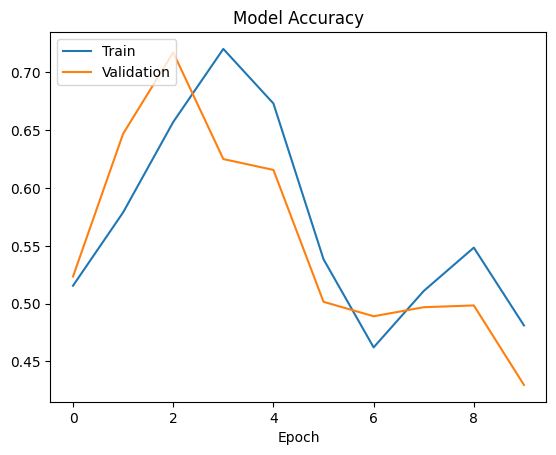

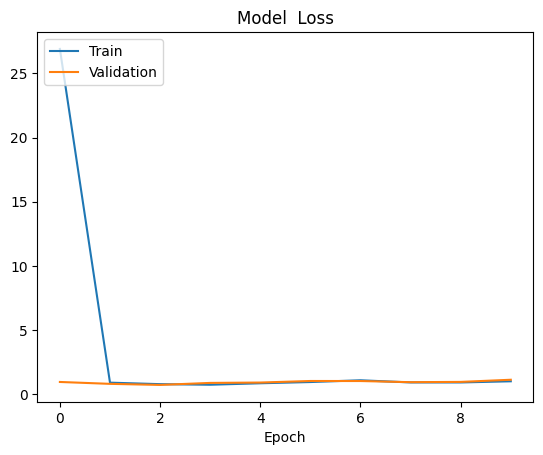

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model  Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model_load = load_model("/kaggle/working/mobilenetv2.h5")

In [15]:
image_data = "/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Testing/meningioma/Te-meTr_0000.jpg"
images = image.load_img(image_data, target_size=(224, 224))
image_to_arrays = image.img_to_array(images)
image_to_arrays = np.expand_dims(image_to_arrays, axis=0)
image_to_arrays /=255.

In [16]:
predictions = model.predict(image_to_arrays)
print(f"Predictiosn Results iS : {predictions}")

1/1 [==============================] - 1s 1s/step
Predictiosn Results iS : [[0.28728664 0.28863233 0.06749221 0.35658875]]


In [17]:
label_information = ['Glioma', "Meningioma", "No-Tumor", "Pitutiary"]
predicted_class = label_information[np.argmax(predictions)]
print(f"Predictiosn Class is : {predicted_class}")

Predictiosn Class is : Pitutiary


1. Pre- Trained Model -- MobileNetV2 (Image Net)
2. Transfer Learning -- Base Model (MobileNetV2) + Proposed Model (FCNN)
3. Fine Tuning

In [18]:
# feature*weights + bias ==> 

In [19]:
# base_model.layers[2].get_weights()[0]

In [20]:
for layer in base_model.layers[:100]:
    layer.trainable = True

In [21]:
model.compile(optimizer = Adam(learning_rate=0.0001),
             loss = "categorical_crossentropy", 
             metrics=["accuracy"])

In [22]:
history = model.fit(trainGenerator, 
                   steps_per_epoch = trainGenerator.n//trainGenerator.batch_size,
                   epochs=10,
                   validation_data = validationGenerator,
                   validation_steps= validationGenerator.n//validationGenerator.batch_size)

Epoch 1/10
178/178 [==============================] - 97s 432ms/step - loss: 1.2194 - accuracy: 0.4150 - val_loss: 1.1537 - val_accuracy: 0.4156
Epoch 2/10
178/178 [==============================] - 76s 427ms/step - loss: 1.1994 - accuracy: 0.4282 - val_loss: 1.1886 - val_accuracy: 0.4062
Epoch 3/10
178/178 [==============================] - 77s 434ms/step - loss: 1.0689 - accuracy: 0.4644 - val_loss: 1.2221 - val_accuracy: 0.3969
Epoch 4/10
178/178 [==============================] - 77s 430ms/step - loss: 1.0758 - accuracy: 0.4757 - val_loss: 1.1960 - val_accuracy: 0.4031
Epoch 5/10
178/178 [==============================] - 76s 429ms/step - loss: 1.0231 - accuracy: 0.4755 - val_loss: 1.1447 - val_accuracy: 0.4203
Epoch 6/10
178/178 [==============================] - 76s 428ms/step - loss: 1.0028 - accuracy: 0.4877 - val_loss: 1.2090 - val_accuracy: 0.4141
Epoch 7/10
178/178 [==============================] - 76s 428ms/step - loss: 0.9421 - accuracy: 0.4838 - val_loss: 1.1872 - val_ac

In [23]:
test_loss, test_accuracy = model.evaluate(validationGenerator,
                               steps = validationGenerator.n//validationGenerator.batch_size)
print(f"Test Loss :{test_loss}\nTest Accuracy :{test_accuracy}")
model_predcitions = model.predict(validationGenerator,
                               steps = validationGenerator.n/validationGenerator.batch_size)
y_actual = validationGenerator.classes
y_pred = np.argmax(model_predcitions, axis = 1)

20/20 [==============================] - 8s 378ms/step - loss: 1.2764 - accuracy: 0.4547
Test Loss :1.2764440774917603
Test Accuracy :0.4546875059604645
20/20 [==============================] - 9s 395ms/step


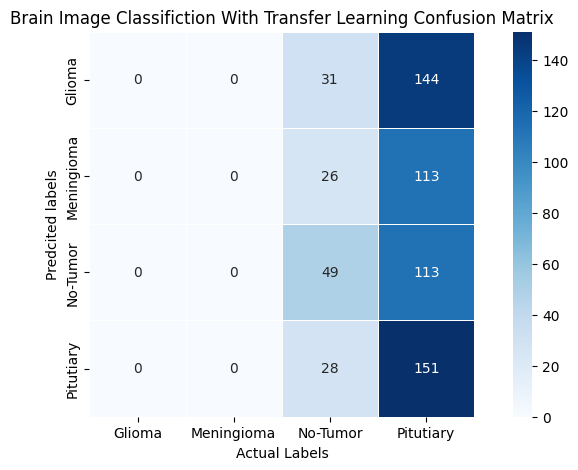

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize = (10, 5))
sns.heatmap(cm, annot = True, 
           fmt = "d", linewidths = 0.4,
           square = True,
           cmap = "Blues",
           xticklabels = label_information, 
           yticklabels = label_information)
plt.xlabel("Actual Labels")
plt.ylabel("Predcited labels")
plt.title("Brain Image Classifiction With Transfer Learning Confusion Matrix")
plt.show()